In [14]:
import pandas as pd
import numpy as np
from numpy import arccos
import nltk
nltk.download("punkt")
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
from unidecode import unidecode
!pip install -U spacy
import spacy
import sys
!{sys.executable} -m spacy download en_core_web_sm
spacy_nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                              0.0/12.8 MB ? eta -:--:--
                                              0.2/12.8 MB 13.4 MB/s eta 0:00:01
     --                                       0.8/12.8 MB 10.5 MB/s eta 0:00:02
     -----                                    1.7/12.8 MB 15.4 MB/s eta 0:00:01
     ---------                                3.1/12.8 MB 17.9 MB/s eta 0:00:01
     ---------------                          5.1/12.8 MB 23.1 MB/s eta 0:00:01
     --------------------------               8.4/12.8 MB 31.7 MB/s eta 0:00:01
     -----------------------------------     11.6/12.8 MB 54.4 MB/s eta 0:00:01
     --------------------------------------  12.8/12.8 MB 59.5 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 43.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [15]:
def on_bad_line(values):
    return values[:7]

columns_mapping = {
    0: 'genre',
    1: 'filename',
    2: 'year',
    3: 'index',
    4: 'score',
    5: 'sentence1',
    6: 'sentence2'
}

# quotings 3 = csv.QUOTE_NONE
train_df = pd.read_csv('Dataset/sts-train.csv', sep="\t", on_bad_lines=on_bad_line, engine='python', header=None, encoding='utf-8', quoting=3).rename(columns=columns_mapping)
print(f'shape of the Dataframe {train_df.shape}')
train_df.head(10)

shape of the Dataframe (5749, 7)


,genre,filename,year,index,score,sentence1,sentence2
0,main-captions,MSRvid,2012test,1,5.00,A plane is taking off.,An air plane is taking off.
1,main-captions,MSRvid,2012test,4,3.80,A man is playing a large flute.,A man is playing a flute.
2,main-captions,MSRvid,2012test,5,3.80,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...
3,main-captions,MSRvid,2012test,6,2.60,Three men are playing chess.,Two men are playing chess.
4,main-captions,MSRvid,2012test,9,4.25,A man is playing the cello.,A man seated is playing the cello.
5,main-captions,MSRvid,2012test,11,4.25,Some men are fighting.,Two men are fighting.
6,main-captions,MSRvid,2012test,12,0.50,A man is smoking.,A man is skating.
7,main-captions,MSRvid,2012test,13,1.60,The man is playing the piano.,The man is playing the guitar.
8,main-captions,MSRvid,2012test,14,2.20,A man is playing on a guitar and singing.,A woman is playing an acoustic guitar and sing...
9,main-captions,MSRvid,2012test,16,5.00,A person is throwing a cat on to the ceiling.,A person throws a cat on the ceiling.


In [16]:
dev_df = pd.read_csv('Dataset/sts-dev.csv', sep="\t", on_bad_lines=on_bad_line, engine='python', header=None, encoding='utf-8', quoting=3).rename(columns=columns_mapping)
print(f'shape of the Dataframe {dev_df.shape}')

test_df = pd.read_csv('Dataset/sts-test.csv', sep="\t", on_bad_lines=on_bad_line, engine='python', header=None, encoding='utf-8', quoting=3).rename(columns=columns_mapping)
print(f'shape of the Dataframe {test_df.shape}')

shape of the Dataframe (1500, 7)
shape of the Dataframe (1379, 7)


In [17]:
sentences1 = train_df["sentence1"]
sentences2 = train_df["sentence2"]
sentences_list = np.unique(np.concatenate((np.ravel(sentences1.values),np.ravel(sentences2.values))))

print(f"Total number of sentences: {len(sentences_list)}")

Total number of sentences: 10566


In [5]:
def remove_special_chars(text):
    regex = '[' + punctuation + ']'
    return re.sub(regex,'',unidecode(text)).lower()

def remove_stop_words(text):
    stop_words = stopwords.words('english')
    return ' '.join([word for word in text.split() if word not in stop_words])

def lemmatize(text):
    parsed_sentence = spacy_nlp(str(text))
    lemmatized_sentence = ' '.join([word.lemma_ for word in parsed_sentence])
    return lemmatized_sentence

def substitute_number(sentence):
    return re.sub(r'\d+', ' number ', sentence)

#TODO mostrare differenze tra originale e lemmatizzazione


no_punct_sentences_list = np.array([remove_special_chars(string) for string in sentences_list])
clean_sentences_list = np.array([remove_stop_words(string) for string in no_punct_sentences_list])
lemmatized_sentences_list = np.array([remove_stop_words(lemmatize(remove_special_chars(sentence)).lower()) for sentence in clean_sentences_list])



print(sentences_list[:5])
print(clean_sentences_list[:5])
print(lemmatized_sentences_list[:5])

[' - Income, top rate:  percent.' ' Foxe was mostly frozen.'
 " billion . Everyone in the world at Mexico's current prosperity level."
 ' warmed.C from the year prior.'
 '"Americans don\'t cut and run, we have to see this misadventure through," she said.']
['income top rate percent' 'foxe mostly frozen'
 'billion everyone world mexicos current prosperity level'
 'warmedc year prior' 'americans dont cut run see misadventure said']
['income top rate percent' 'foxe mostly frozen'
 'billion everyone world mexicos current prosperity level'
 'warmedc year prior' 'americans cut run see misadventure say']


In [6]:
array_len = np.vectorize(len)(sentences_list)
mean_len = np.mean(array_len)
print(f"Mean length of sentences in characters: {mean_len:.2f}")

Mean length of sentences in characters: 59.37


In [7]:
clean_dataset = pd.DataFrame({
    'sentence1': train_df['sentence1'].map(remove_special_chars).map(remove_stop_words),
    'sentence2': train_df['sentence2'].map(remove_special_chars).map(remove_stop_words),
    'score': train_df['score'] / 5
})

clean_test_dataset = pd.DataFrame({
    'sentence1': test_df['sentence1'].map(remove_special_chars).map(remove_stop_words),
    'sentence2': test_df['sentence2'].map(remove_special_chars).map(remove_stop_words),
    'score': test_df['score'] / 5
})

no_number_dataset = pd.DataFrame({
    'sentence1': clean_dataset['sentence1'].map(substitute_number),
    'sentence2': clean_dataset['sentence2'].map(substitute_number),
    'score': clean_dataset['score']
})

lemmatized_dataset = pd.DataFrame({
    'sentence1': clean_dataset['sentence1'].map(lemmatize),
    'sentence2': clean_dataset['sentence2'].map(lemmatize),
    'score': clean_dataset['score']
})

# Transformers
![Comparison bi-encoder and cross-encoder](https://raw.githubusercontent.com/UKPLab/sentence-transformers/master/docs/img/Bi_vs_Cross-Encoder.png)

## Bi-Encoders
Bi-Encoders produce for a given sentence a sentence embedding. We pass to a BERT independently the sentences A and B, which result in the sentence embeddings u and v. These sentence embedding can then be compared using cosine similarity

In this example we fine tune a pre-trained SentenceTransformer model on the STS benchmark dataset.

Reimers, N., & Gurevych, I. (2019). Sentence-BERT: Sentence embeddings using Siamese BERT-networks. In arXiv [cs.CL]. http://arxiv.org/abs/1908.10084

### Fine Tuning a pre-trained model
In this example we fine tune a pre-trained model. The model was first trained on NLI data, we now finetune it on the STS benchmark dataset.

In [2]:
from torch.utils.data import DataLoader
import math
from sentence_transformers import SentenceTransformer, LoggingHandler, losses, util, InputExample
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
import logging
from datetime import datetime

c:\Users\andre\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [43]:
#### Just some code to print debug information to stdout
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])

# Read the dataset
model_name = 'nli-distilroberta-base-v2'
train_batch_size = 16
num_epochs = 10
model_save_path = 'output/bi_encoder_fine_tuning-'+model_name+'-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Load a pre-trained sentence transformer model
model = SentenceTransformer(model_name)

2023-05-27 10:46:45 - Load pretrained SentenceTransformer: nli-distilroberta-base-v2
2023-05-27 10:46:46 - Use pytorch device: cpu


In [44]:
# Convert the dataset to a DataLoader ready for training
logging.info("Read STSbenchmark train dataset")

train_samples = []
dev_samples = []
test_samples = []

# Loading datasets from csv files
for idx, row in train_df.iterrows():

    score = float(row['score']) / 5.0  # Normalize score to range 0 ... 1

    #As we want to get symmetric scores, i.e. CrossEncoder(A,B) = CrossEncoder(B,A), we pass both combinations to the train set
    train_samples.append(InputExample(texts=[row['sentence1'], row['sentence2']], label=score))
    train_samples.append(InputExample(texts=[row['sentence2'], row['sentence1']], label=score))

for idx, row in dev_df.iterrows():
    score = float(row['score']) / 5.0  # Normalize score to range 0 ... 1
    dev_samples.append(InputExample(texts=[row['sentence1'], row['sentence2']], label=score))

for idx, row in test_df.iterrows():
    score = float(row['score']) / 5.0  # Normalize score to range 0 ... 1
    test_samples.append(InputExample(texts=[row['sentence1'], row['sentence2']], label=score))

2023-05-27 10:46:57 - Read STSbenchmark train dataset


In [45]:
# We wrap train_samples into a pytorch DataLoader
train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=train_batch_size)
# We use cosine similarity as loss function.
train_loss = losses.CosineSimilarityLoss(model=model)

# Development set: Measure correlation between cosine score and gold labels
logging.info("Read STSbenchmark dev dataset")
evaluator = EmbeddingSimilarityEvaluator.from_input_examples(dev_samples, name='sts-dev')

# Configure the training
warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up
logging.info("Warmup-steps: {}".format(warmup_steps))

2023-05-27 10:47:04 - Read STSbenchmark dev dataset
2023-05-27 10:47:04 - Warmup-steps: 719


In [41]:
# Testing the model before fine-tuning
test_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(test_samples, name='sts-test')
model.evaluate(evaluator)

2023-05-27 10:42:58 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-dev dataset:
2023-05-27 10:43:56 - Cosine-Similarity :	Pearson: 0.8580	Spearman: 0.8638
2023-05-27 10:43:56 - Manhattan-Distance:	Pearson: 0.8469	Spearman: 0.8463
2023-05-27 10:43:56 - Euclidean-Distance:	Pearson: 0.8488	Spearman: 0.8483
2023-05-27 10:43:56 - Dot-Product-Similarity:	Pearson: 0.8096	Spearman: 0.8086


0.8637726299065401

In [ ]:
# Train the model
model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator,
          epochs=num_epochs,
          evaluation_steps=1000,
          warmup_steps=warmup_steps,
          output_path=model_save_path)

In [51]:
# Load the stored model and evaluate its performance on STS benchmark dataset
model = SentenceTransformer(model_save_path)
test_evaluator(model, output_path=model_save_path)

2023-05-27 15:14:27 - Load pretrained SentenceTransformer: training_stsbenchmark_continue_training-nli-distilroberta-base-v2-2023-05-27_12-22-39
2023-05-27 15:14:28 - Use pytorch device: cpu
2023-05-27 15:14:28 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-test dataset:
2023-05-27 15:15:08 - Cosine-Similarity :	Pearson: 0.8646	Spearman: 0.8658
2023-05-27 15:15:08 - Manhattan-Distance:	Pearson: 0.8480	Spearman: 0.8497
2023-05-27 15:15:08 - Euclidean-Distance:	Pearson: 0.8501	Spearman: 0.8517
2023-05-27 15:15:08 - Dot-Product-Similarity:	Pearson: 0.8249	Spearman: 0.8200


0.86583234968324

As we can see fine-tuning the model on the STS benchmark dataset improves the performance.

### Testing a pre-trained bi-encoder model already fine-tuned on STSb

In [11]:
model_name = 'stsb-distilroberta-base-v2'
# Load a pre-trained sentence transformer model
pre_trained_model = SentenceTransformer(model_name)

In [50]:
test_evaluator(pre_trained_model)

2023-05-27 11:48:36 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-test dataset:
2023-05-27 11:49:26 - Cosine-Similarity :	Pearson: 0.8634	Spearman: 0.8641
2023-05-27 11:49:26 - Manhattan-Distance:	Pearson: 0.8409	Spearman: 0.8411
2023-05-27 11:49:26 - Euclidean-Distance:	Pearson: 0.8436	Spearman: 0.8441
2023-05-27 11:49:26 - Dot-Product-Similarity:	Pearson: 0.8211	Spearman: 0.8141


0.8641186332195347

## Cross-Encoders

With Cross-Encoders we path both sentences at once to BERT. The output is then used to predict a similarity. A Cross-Encoder does not produce a sentence embedding, they are more accurate, but also slower than Bi-Encoders.

In [3]:
from sentence_transformers.cross_encoder import CrossEncoder
from sentence_transformers.cross_encoder.evaluation import CECorrelationEvaluator

In [53]:
#Define our Cross-Encoder
train_batch_size = 16
num_epochs = 30
model_save_path = 'output/cross_encoder_training-'+model_name+'-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

#We use distilroberta-base as base model and set num_labels=1, which predicts a continous score between 0 and 1
model = CrossEncoder('distilroberta-base', num_labels=1)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.out_proj.weig

2023-05-27 15:58:06 - Use pytorch device: cpu


In [ ]:
# We add an evaluator, which evaluates the performance during training
evaluator = CECorrelationEvaluator.from_input_examples(dev_samples, name='sts-dev')


# Configure the training
warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up
logging.info("Warmup-steps: {}".format(warmup_steps))


# Train the model
model.fit(train_dataloader=train_dataloader,
          evaluator=evaluator,
          epochs=num_epochs,
          warmup_steps=warmup_steps,
          output_path=model_save_path)

In [56]:
##### Load model and eval on test set
model = CrossEncoder('output\cross_encoder_training-distilroberta-base-2023-05-27_16-39-21')

evaluator = CECorrelationEvaluator.from_input_examples(test_samples, name='sts-test')
evaluator(model)

2023-05-27 16:40:19 - Use pytorch device: cpu
2023-05-27 16:40:19 - CECorrelationEvaluator: Evaluating the model on sts-test dataset:
2023-05-27 16:41:25 - Correlation:	Pearson: 0.8533	Spearman: 0.8439


0.8438616922335536

### Testing pre-trained cross-encoder models already fine-tuned on STSb

In [59]:
##### Testing stsb-distilroberta-base
model = CrossEncoder('cross-encoder/stsb-distilroberta-base', num_labels=1)
evaluator = CECorrelationEvaluator.from_input_examples(test_samples, name='sts-test')
evaluator(model)

2023-05-27 17:07:39 - Use pytorch device: cpu
2023-05-27 17:07:39 - CECorrelationEvaluator: Evaluating the model on sts-test dataset:
2023-05-27 17:09:07 - Correlation:	Pearson: 0.8851	Spearman: 0.8792


0.8791573934188543

In [55]:
##### Testing stsb-roberta-large
model = CrossEncoder('cross-encoder/stsb-roberta-large', num_labels=1)

evaluator = CECorrelationEvaluator.from_input_examples(test_samples, name='sts-test')
evaluator(model)

2023-05-27 16:02:31 - Use pytorch device: cpu
2023-05-27 16:02:31 - CECorrelationEvaluator: Evaluating the model on sts-test dataset:
2023-05-27 16:08:45 - Correlation:	Pearson: 0.9170	Spearman: 0.9147


0.914689659080599

As we can see cross-encoders are more accurate, but also slower than bi-encoders. They reach state-of-the-art performance on the STS benchmark dataset.

## Clustering using Bi-Encoders

In [18]:
pre_trained_model = SentenceTransformer('stsb-distilroberta-base-v2')
sentences_list_embeddings = pre_trained_model.encode(sentences_list, show_progress_bar=True)

Batches: 100%|██████████| 331/331 [04:04<00:00,  1.35it/s]


[[18.321922  17.209478  18.269783  ... 17.607737  20.381697  21.753805 ]
 [18.602247  16.861237  18.527231  ... 17.45291   17.193768  20.18104  ]
 [17.097128  17.364855  17.597054  ... 17.554117  19.786682  19.870926 ]
 ...
 [15.7166395 15.080582  15.504425  ... 15.244473  17.993933  19.641665 ]
 [15.919892  14.3445    15.364662  ... 15.151398  18.155754  19.259418 ]
 [15.331191  13.734313  14.350514  ... 13.950357  19.090204  18.423164 ]]
[12 22 12 ...  7 19 22]


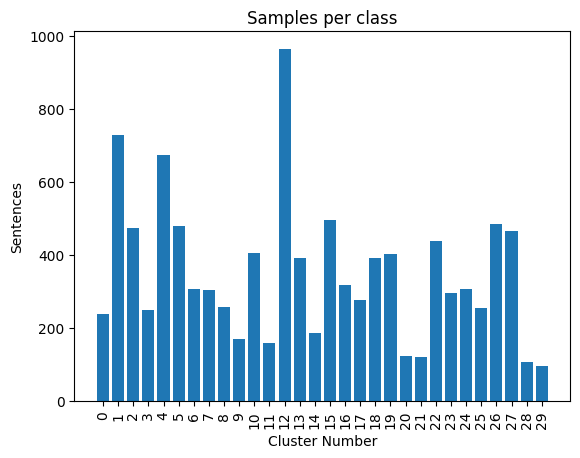

In [103]:
k = 30
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
cluster_matrix = kmeans.fit_transform(sentences_list_embeddings)
print(cluster_matrix)
clusters = np.argmin(cluster_matrix, axis=-1)
print(clusters)

uniques, counts = np.unique(clusters, return_counts=True)
plt.bar(uniques, counts)
plt.xlabel('Cluster Number')
plt.ylabel('Sentences')
plt.xticks(uniques, rotation=90)
plt.title('Samples per class')
plt.show()

In [117]:
top_sentence_per_cluster = []

# print the top 10 words in each cluster
for i in range(k):
    centroid = kmeans.cluster_centers_[i]    
    sorted_terms = centroid.argsort()[::-1]
    print(f"\nCluster {i}")

    i_labelled_sentence_vectors = sentences_list_embeddings[kmeans.labels_ == i]
    i_labelled_sentences = np.array(sentences_list)[kmeans.labels_ == i]
    # sorting the terms to most similar to the centroid
    sorted_sentences = i_labelled_sentences[np.argsort(cosine_similarity(i_labelled_sentence_vectors, [centroid]).flatten())[::-1]]
    top_sentence_per_cluster.append(sorted_sentences[0])

    for idx, sentence in enumerate(sorted_sentences[:10]):
        print(str(idx + 1) + ") ",sentence)


Cluster 0
1)  a boy jumps into the blue pool water.
2)  A young boy jumping in the air at the beach.
3)  A boy doing a back flip into a swimming pool.
4)  A boy jumping in the air on the beach.
5)  A boy goes down an inflatable slide.
6)  A little boy and a little girl playing together outside.
7)  A boy jumps into a not-so-crowded public pool.
8)  A little boy in denim overalls slides down an orange slide.
9)  A child is jumping into a swimming pool.
10)  A boy doing a wheelie on a plank with the beach in the background.

Cluster 1
1)  In an interview, Ms. Healey, who is a criminologist, said many lawmakers here and across the country shared a wariness toward capital punishment.
2)  In an interview, Healey, who is a criminologist, acknowledged that much of the sentiment among legislators here and across the country was wariness toward capital punishment.
3)  The differences between Grassley and Thomas on energy and Medicare have become so pointed that other members say their angry pe

In [101]:
from sklearn.decomposition import PCA
pca_model = PCA(n_components=50, random_state=42)
pca_embeddings = pca_model.fit_transform(sentences_list_embeddings)

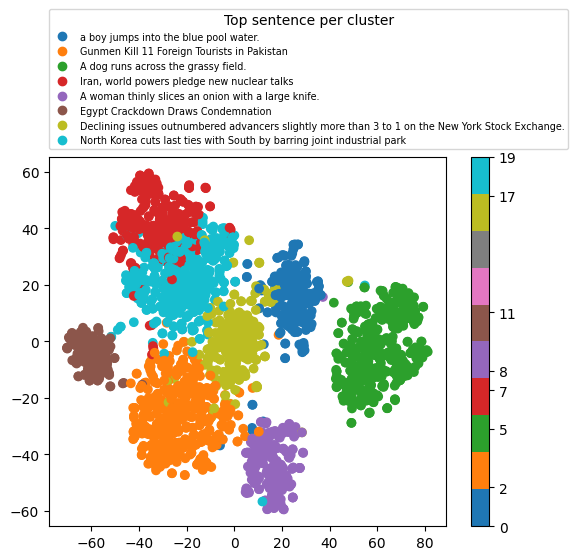

In [131]:
# visualize selected clusters using manifold learning
from sklearn.manifold import TSNE
from matplotlib import ticker

selected_clusters = [0, 2, 5, 7, 8, 11, 17, 19]
cluster_mask = np.isin(clusters, selected_clusters)

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(pca_embeddings[cluster_mask])
# plot the clusters printng the color scale
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters[cluster_mask], cmap='tab10')
handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, np.array(top_sentence_per_cluster)[selected_clusters], loc='lower left', bbox_to_anchor=(0, 1.02, 1, 0.2), ncol=1, borderaxespad=0., fontsize='x-small', title='Top sentence per cluster')
# (generate plot here)
cb = plt.colorbar()
cb.set_ticks(selected_clusters)
plt.show()
